# KNN

In [21]:
# Only Uniform Weighting Strategy Supported as of now!
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.neighbors import KNeighborsClassifier as cuKNN
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['brute']  # cuML KNN only supports brute force algorithm
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    model = cuKNN(
        **params
    )

    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_scaled, y_train):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'KNN_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'n_neighbors': [
        max(1, best_params['n_neighbors'] - 2),
        best_params['n_neighbors'],
        best_params['n_neighbors'] + 2
    ],
    'weights': [best_params['weights']],
    'metric': [best_params['metric']],
    'algorithm': ['brute']
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = cuKNN(
        **params
    )

    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
joblib.dump(best_model, 'KNN_GPU_final.pkl')

# For predictions
y_pred = best_model.predict(X_test_scaled)

Total parameter combinations: 10

Combination 1/10 at 05:52:21
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Training Score: 0.9824
Test Score: 0.9596
Iteration Time: 00:00:02
New best score: 0.9596

Combination 2/10 at 05:52:23
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Training Score: 0.9742
Test Score: 0.9566
Iteration Time: 00:00:01

Combination 3/10 at 05:52:25
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Training Score: 0.9680
Test Score: 0.9526
Iteration Time: 00:00:01

Combination 4/10 at 05:52:27
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Training Score: 0.9615
Test Score: 0.9497
Iteration Time: 00:00:01

Combination 5/10 at 05:52:29
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Training Score: 0.9562
Test Score: 

In [22]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test_cpu, y_pred_cpu))
print(confusion_matrix(y_test_cpu, y_pred_cpu))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     16179
         1.0       0.95      0.93      0.94     15932

    accuracy                           0.94     32111
   macro avg       0.94      0.94      0.94     32111
weighted avg       0.94      0.94      0.94     32111

[[15418   761]
 [ 1159 14773]]


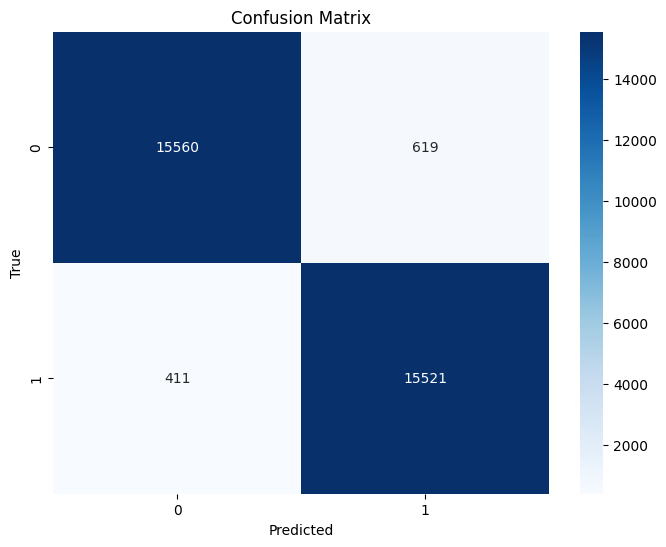

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions and test labels to CPU for plotting
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred.values.get()

# Create and plot confusion matrix
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()